# Skin Disease Prediction through Image Analysis of Diverse Skin Tones

---

# Overview
In this project the "client" was a large hospital executive board that was looking to find a triage solution for long wait times in dermatology. The goal of this project is to provide education on how AI predictive modeling can be a powerful tool to triaging patients and ensuring patients get prompt care that are exhibiting high risk diseases. There are some limitations and ethical considerations when using AI in medicine, including the importance of using models that have been built on images of diverse skin tones. Models in this project have been trained on the Stanford University "Diverse Dermatology Images" Dataset. All rights to these images belong to Stanford School of Medicine.  

---

# Problem Statememt 

Dermatologists diagnose a variety of skin diseases, most commonly skin cancers and other inflammatory conditions. AI predictive modeling is a promising dermatology tool to aid in early detection of skin cancer and other skin diseases. Historically, most dermatology models have not been trained on images of diverse skin tones, leading to potential biases in algorithm performance. This project aims to utilize Convolutional Neural Networks on a Stanford University “Diverse Dermatology Images” Dataset, to predict malignant skin diseases, inclusive of all skin tones. 

The data used from this project can be found from the following source: [Stanford AIMI Shared Datasets](https://stanfordaimi.azurewebsites.net/datasets/35866158-8196-48d8-87bf-50dca81df965). All image rights to the Diverse Dermatology Images Dataset (DDI) belong to Stanford University School of Medicine. If you would like to replicate this project, you will need to register as an individual user and comply with all terms of their Research Use Agreement. 

---

# Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
|DDI_file|object|DDI|Image Path|
|skin_tone|integer|DDI|Skin tone present, where 12 indicates tone falls into Fitzpatrick range I-II, 34 indicates tone falls into Fitzpatrick range III-IV and 56 indicates tone falls into Fitzpatrick range V-VI|
|malignant|integer|DDI|Numerical binary representation of each class, where 0 is "benign" and 1 is "malignant"|
|disease|object|DDI|Type of disease present on image|

---







# Part 1: Data Cleaning/EDA

This section includes initial data cleaning and Exploratory Data Analysis (EDA). The dataset used was a combination of images and a corresponding csv file that contained the image file name, skin tone, diagnosis and type of disease. Upon reading in the csv file, image diagnosis was changed to 0's and 1's for binary classification, where 0 indicated a benign image and 1 indicated a malignant image. The dataset was then split up into training, validation and testing sets using the csv. Similar distribution of classes in each set were confirmed. From there, the file name was used to loop through each set and shuttle images to the appropriate file directories. Image sizes in pixels were plotted, and image size outliers were removed. Finally, EDA was performed. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
import os 
import dask.bag as db
import pickle

from dask.diagnostics import ProgressBar
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## All functions used in this notebook are in the following cell:

In [ ]:
#function to return images dimensions
def get_dimensions(file):
  im = plt.imread(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

#function to add image sizes to original train/val/test dataframes 
def add_image_size(directory_path, df):
  for image in directory_path:
    image_list = [directory_path + image for image in os.listdir(directory_path)]
    dims = db.from_sequence(image_list).map(get_dimensions)
    dims_df=pd.DataFrame(dims, columns=['height', 'width'], index=df.index)
    df['image_height']=dims_df['height']
    df['image_width']=dims_df['width']
  return df

In [4]:
#read in csv
csv=pd.read_csv('/content/drive/MyDrive/DSI/ddidiversedermatologyimages/ddi_metadata.csv', index_col='Unnamed: 0')
csv.head()

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides
3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,5,000005.png,12,True,basal-cell-carcinoma


In [5]:
#converting malignant column to binary where 1 is True and 0 is False 
csv['malignant']=np.where(csv['malignant']==True, 1, 0)

## Train/Validation/Test Split

Using the csv, images were randomly split into training, validation and testing sets. Classes were evenly distributed in each set. Minor class imbalance is noted. 

In [5]:
#train val split: 70/20/10

# one line split 
train, validation, test = np.split(csv.sample(frac=1, random_state=42), [int(.7*len(csv)),
int(.9*len(csv))])

In [6]:
#Checking
print(train.shape)
print(validation.shape)
print(test.shape)

(459, 5)
(131, 5)
(66, 5)


In [7]:
#Checking to make sure there is roughly the same ratio in each set

print((train['malignant']==1).value_counts())
print((validation['malignant']==1).value_counts())
print((test['malignant']==1).value_counts())

False    338
True     121
Name: malignant, dtype: int64
False    98
True     33
Name: malignant, dtype: int64
False    49
True     17
Name: malignant, dtype: int64


## Using shutil library to move images into the respective image directories (locally or cloud)

In [8]:
#Moving images into the correct train/val/test folders 

#paths 
source_path='/content/drive/MyDrive/DSI/ddidiversedermatologyimages'
train_destination_path='/content/drive/MyDrive/DSI/train_ddi'

#move train files to correct folder 
for row in train['DDI_file']:
    shutil.move(f'{source_path}/{row}', train_destination_path, copy_function = shutil.copytree)

In [9]:
#repeating image move for valiation and test sets 
val_destination_path='/content/drive/MyDrive/DSI/val_ddi'
test_destination_path='/content/drive/MyDrive/DSI/test_ddi'

#move validation files to correct folder 
for row in validation['DDI_file']:
    shutil.move(f'{source_path}/{row}', val_destination_path, copy_function = shutil.copytree)

#move test files to correct folder 
for row in test['DDI_file']:
    shutil.move(f'{source_path}/{row}', test_destination_path, copy_function = shutil.copytree)

In [10]:
#Checking to make sure the correct images went to the correct folder 
print(train['DDI_file'].sort_values())
print(validation['DDI_file'].sort_values())
print(test['DDI_file'].sort_values())

0      000001.png
2      000003.png
3      000004.png
5      000006.png
6      000007.png
          ...    
649    000650.png
651    000652.png
652    000653.png
654    000655.png
655    000656.png
Name: DDI_file, Length: 459, dtype: object
4      000005.png
14     000015.png
27     000028.png
32     000033.png
35     000036.png
          ...    
622    000623.png
635    000636.png
638    000639.png
645    000646.png
653    000654.png
Name: DDI_file, Length: 131, dtype: object
1      000002.png
13     000014.png
20     000021.png
21     000022.png
34     000035.png
          ...    
600    000601.png
612    000613.png
614    000615.png
640    000641.png
650    000651.png
Name: DDI_file, Length: 66, dtype: object


## Detecting Image Size

It is important to understand the size of each image and potential image size outliers for best modeling results. This information will help to determine how to resize images for modeling, and which pre-trained neural network model will be used. Image height and width was then added back to the original csv dataframe. Outliers were marked as any image with a width larger than 1500 pixels. Outliers were then removed. This method dropped one image each from the test and validation sets. 

[########################################] | 100% Completed | 25.2s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 11.8s


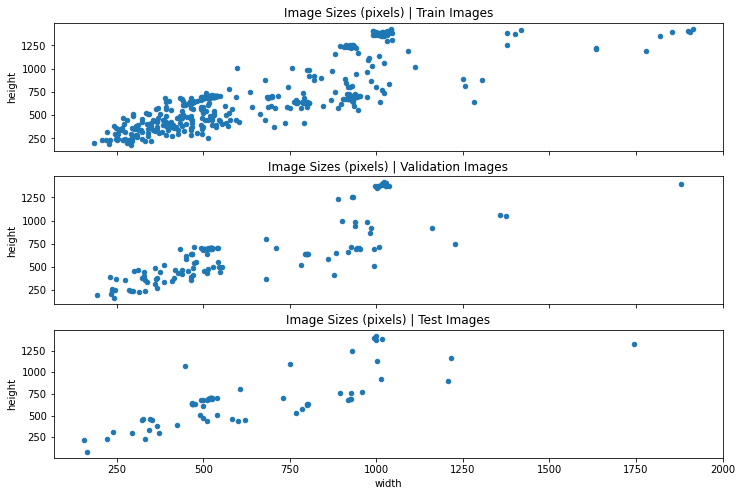

In [11]:
#writing functions to return image size for EDA

#directory paths (will be used again in later functions)
train_path='/content/drive/MyDrive/DSI/train_ddi/'
val_path='/content/drive/MyDrive/DSI/val_ddi/'
test_path='/content/drive/MyDrive/DSI/test_ddi/'

directories_dict = {
    'Train Images': train_path,
    'Validation Images': val_path,
    'Test Images': test_path
}

#loop through folders in directories and return dimensions for each image in dataframe for plotting
fig, ax=plt.subplots(3,1, sharex=True)
i=0

for k,v in directories_dict.items():
  file_path = v
  file_list = [file_path + f for f in os.listdir(file_path)]
  dims = db.from_sequence(file_list).map(get_dimensions)
  with ProgressBar():
    dims = dims.compute()
    dims_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes_df = pd.DataFrame(dims_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'}))
    sizes_df.plot.scatter(figsize=(12,8), x='width', y='height', ax=ax[i])
    ax[i].set_title(f'Image Sizes (pixels) | {k}')
    i+=1;

In [13]:
#applying add_image_size function to train/val/test dataframes 
train=add_image_size(train_path, train)
validation=add_image_size(val_path, validation)
test=add_image_size(test_path, test)

In [15]:
#Mask to find and remove outliers from each set 
train_no_outliers=train.loc[train['image_width'] < 1500]
val_no_outliers=validation.loc[validation['image_width'] < 1500]
test_no_outliers=test.loc[test['image_width'] < 1500]

#save dfs to csv
train_no_outliers.to_csv('/content/drive/MyDrive/DSI/train.csv', index=False)
val_no_outliers.to_csv('/content/drive/MyDrive/DSI/val.csv', index=False)
test_no_outliers.to_csv('/content/drive/MyDrive/DSI/test.csv', index=False)

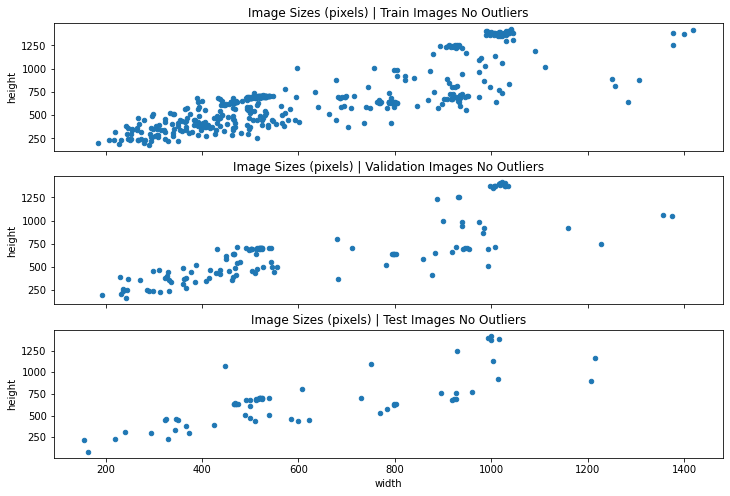

In [16]:
#plotting new image size without outliers

#creating subplots
fig, axes = plt.subplots(3,1, sharex=True, figsize=(12,8))

#grouby for proper variables 
train_sizes = train_no_outliers.groupby(['image_height', 'image_width']).size().reset_index().rename(columns={0:'count'})
val_sizes=val_no_outliers.groupby(['image_height', 'image_width']).size().reset_index().rename(columns={0:'count'})
test_sizes=test_no_outliers.groupby(['image_height', 'image_width']).size().reset_index().rename(columns={0:'count'})

#add DataFrames to subplots
train_sizes.plot.scatter(x='image_width', y='image_height',ax=axes[0])
val_sizes.plot.scatter(x='image_width', y='image_height', ax=axes[1])
test_sizes.plot.scatter(x='image_width', y='image_height', ax=axes[2])
plt.xlabel('width')
axes[0].set_ylabel('height')
axes[1].set_ylabel('height')
axes[2].set_ylabel('height')
axes[0].set_title(f'Image Sizes (pixels) | Train Images No Outliers')
axes[1].set_title(f'Image Sizes (pixels) | Validation Images No Outliers')
axes[2].set_title(f'Image Sizes (pixels) | Test Images No Outliers');

# Exploratory Data Analysis (EDA)

This section begins by looking at summary statistics of each set after image size outliers were removed. Mean image height x width were noted to determine image size for modeling. Train height and width had a mean value of 698.67 x 635.45, validation height x width had a mean value of 678.08 x 630.44 and test height x width had a mean value of 665.00 x 608.34. With this information I decided to use an image size of 512 x 512 for my models. I also noted that my mean majority class in the test set was 26.15%. I then plotted various relationships as shown below. 

In [17]:
#summary statistics for train group with outliers removed
train_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
DDI_ID,451.0,323.574279,190.635663,1.0,157.0,321.0,483.5,656.0
skin_tone,451.0,34.000000,17.721801,12.0,12.0,34.0,56.0,56.0
malignant,451.0,0.263858,0.441213,0.0,0.0,0.0,1.0,1.0
image_height,451.0,698.669623,334.805150,177.0,448.0,643.0,732.0,1429.0
image_width,451.0,635.450111,266.639197,183.0,440.5,526.0,913.0,1418.0


In [18]:
#summary statistics for validation group with outliers removed
val_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
DDI_ID,130.0,343.776923,183.819690,5.0,190.50,366.5,505.25,654.0
skin_tone,130.0,34.507692,16.989393,12.0,12.00,34.0,56.00,56.0
malignant,130.0,0.246154,0.432436,0.0,0.00,0.0,0.00,1.0
image_height,130.0,678.084615,340.539677,155.0,435.75,642.0,709.25,1415.0
image_width,130.0,630.446154,285.366270,192.0,428.75,520.0,931.50,1375.0


In [19]:
#summary statistics for test group with outliers removed 
test_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
DDI_ID,65.0,329.907692,189.442168,2.0,167.0,344.0,477.0,651.0
skin_tone,65.0,32.646154,17.338929,12.0,12.0,34.0,56.0,56.0
malignant,65.0,0.261538,0.442893,0.0,0.0,0.0,1.0,1.0
image_height,65.0,665.000000,294.094638,79.0,456.0,645.0,707.0,1421.0
image_width,65.0,608.338462,257.936479,155.0,467.0,521.0,798.0,1215.0


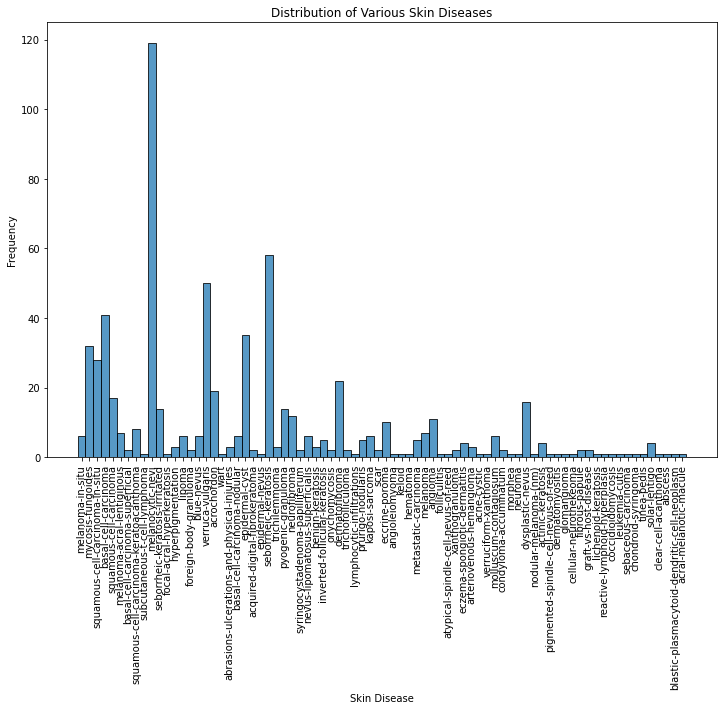

In [20]:
#plot to look at possible skin diseases 
plt.figure(figsize=(12,8))
sns.histplot(data=csv, x='disease')
plt.xticks(rotation=90)
plt.title('Distribution of Various Skin Diseases')
plt.xlabel('Skin Disease')
plt.ylabel('Frequency');

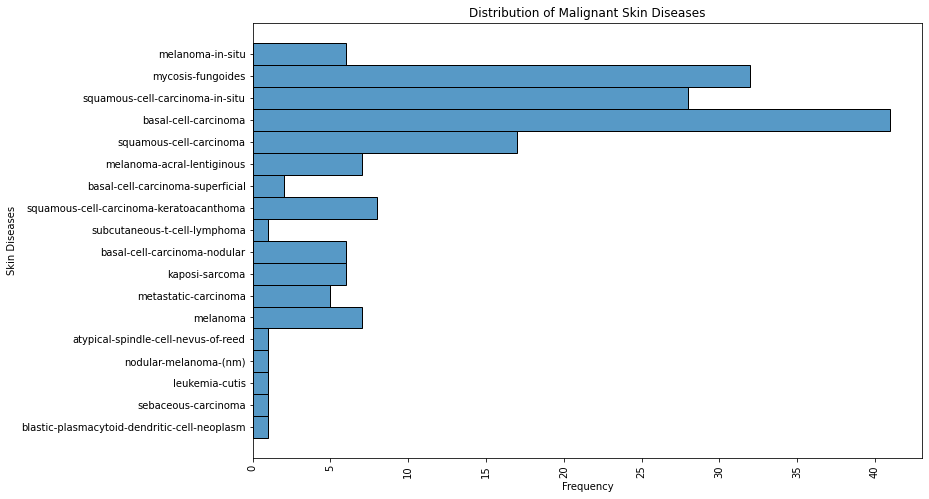

In [6]:
#boolean mask for malignant/benign
malignant_only=(csv[csv['malignant']==1])
benign_only=(csv[csv['malignant']==0])

#distribution of malignant skin diseases 
plt.figure(figsize=(12,8))
sns.histplot(data=malignant_only, y='disease')
plt.xticks(rotation=90)
plt.title('Distribution of Malignant Skin Diseases')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

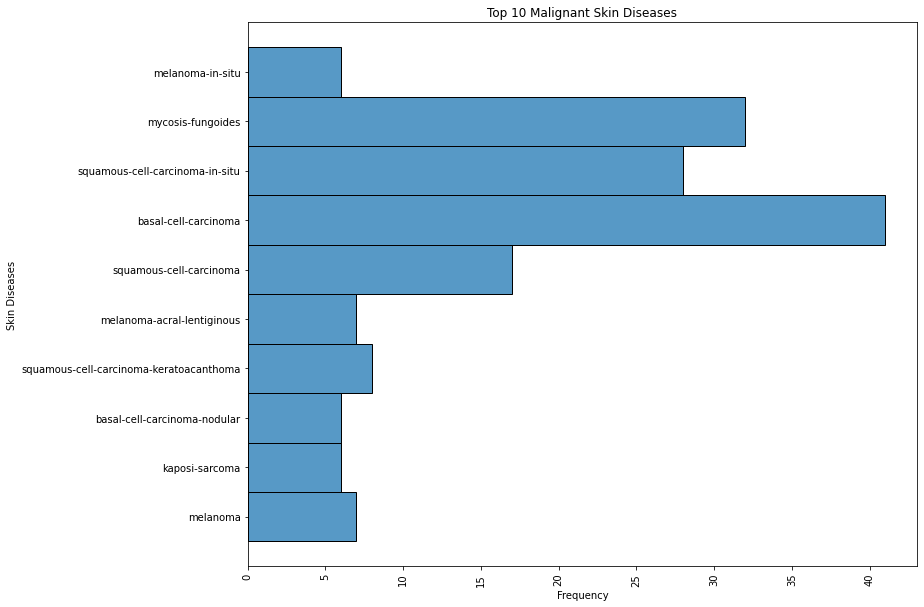

In [7]:
#finding top ten malignant diseases 
top_10_malig=malignant_only['disease'].value_counts().head(10).index.to_list()

loc_malig=malignant_only.loc[malignant_only['disease'].isin(top_10_malig)]

plt.figure(figsize=(12,10))
sns.histplot(data=loc_malig, y='disease')
plt.xticks(rotation=90)
plt.title('Top 10 Malignant Skin Diseases')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

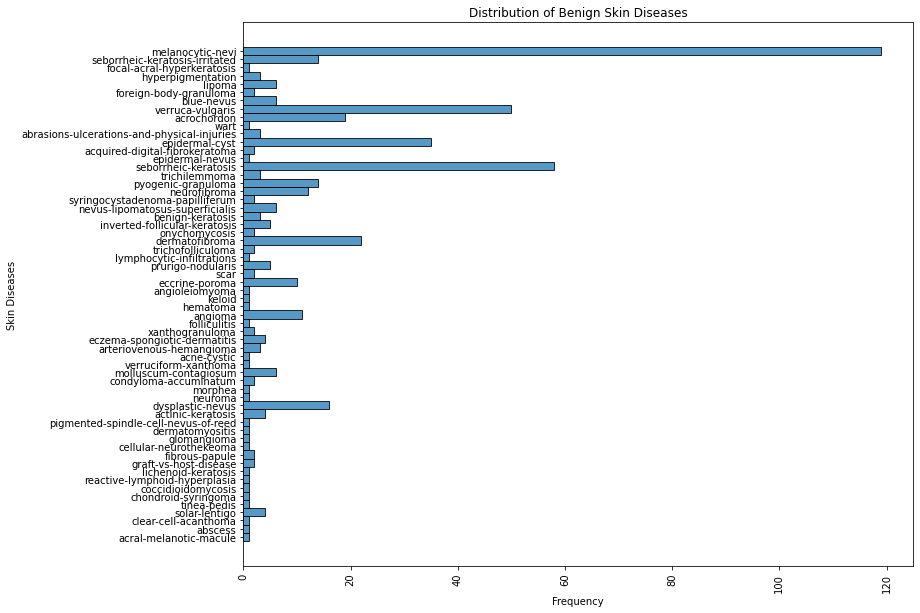

In [8]:
#distribution of benign skin diseases 
plt.figure(figsize=(12,10))
sns.histplot(data=benign_only, y='disease')
plt.xticks(rotation=90)
plt.title('Distribution of Benign Skin Diseases')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

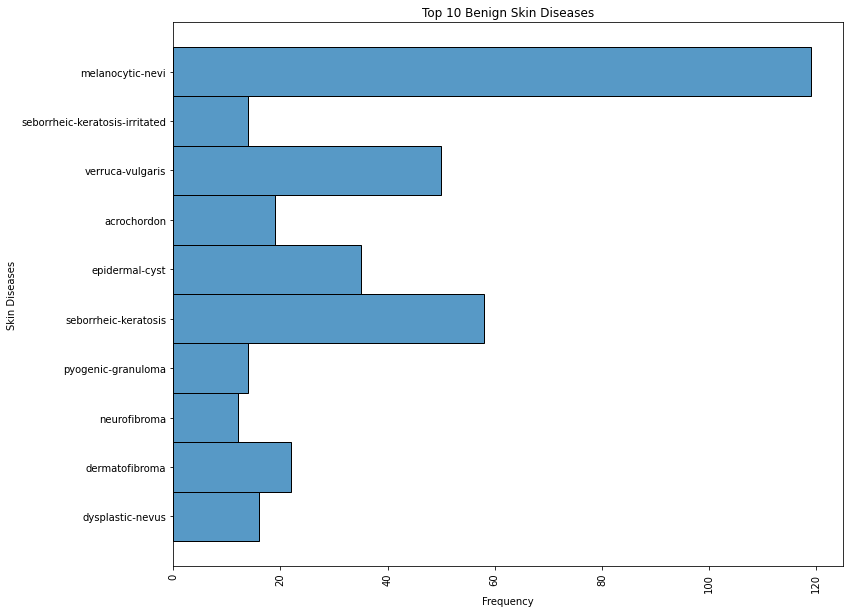

In [9]:
#finding top ten benign diseases 
top_10_benign=benign_only['disease'].value_counts().head(10).index.to_list()

loc_benign=benign_only.loc[benign_only['disease'].isin(top_10_benign)]

plt.figure(figsize=(12,10))
sns.histplot(data=loc_benign, y='disease')
plt.xticks(rotation=90)
plt.title('Top 10 Benign Skin Diseases')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

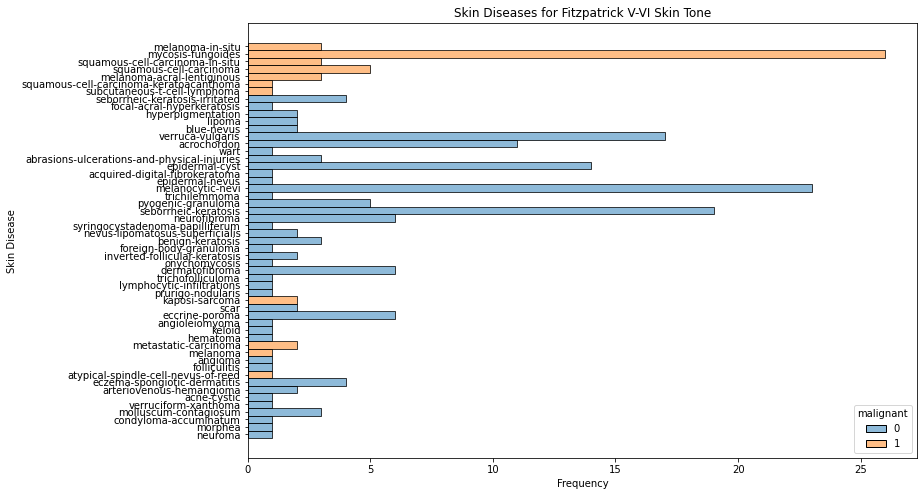

In [10]:
#histogram for top diseases of Fitzpatrick V-VI skin tone 
tone_56=csv.loc[csv['skin_tone']==56]

plt.figure(figsize=(12,8))
sns.histplot(data=tone_56, y='disease', hue='malignant')
plt.title('Skin Diseases for Fitzpatrick V-VI Skin Tone')
plt.ylabel('Skin Disease')
plt.xlabel('Frequency');

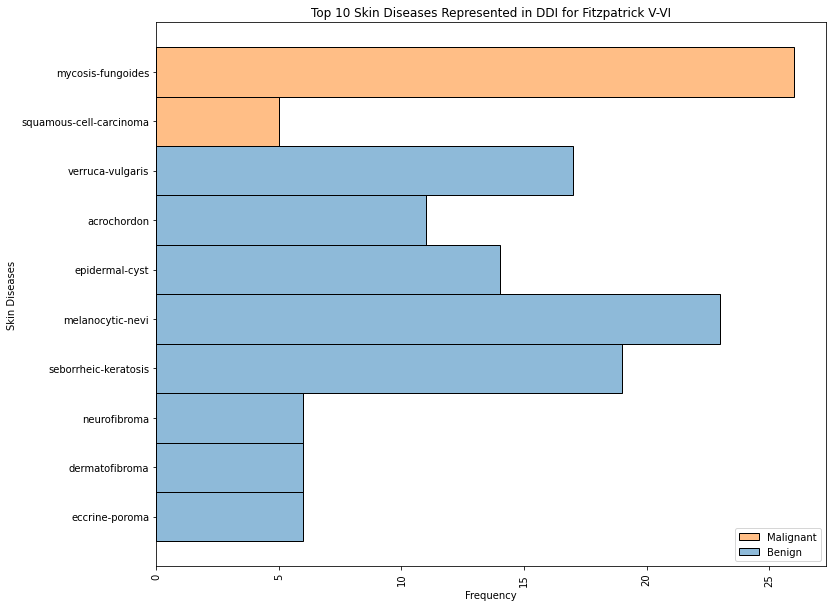

In [18]:
#finding top ten fitzpatrick V-VI skin diseases  
top_10_tone56=tone_56['disease'].value_counts().head(10).index.to_list()

loc_tone56=tone_56.loc[tone_56['disease'].isin(top_10_tone56)]

plt.figure(figsize=(12,10))
sns.histplot(data=loc_tone56, y='disease', hue='malignant')
plt.xticks(rotation=90)
plt.title('Top 10 Skin Diseases Represented in DDI for Fitzpatrick V-VI')
plt.legend(labels=['Malignant', 'Benign'])
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

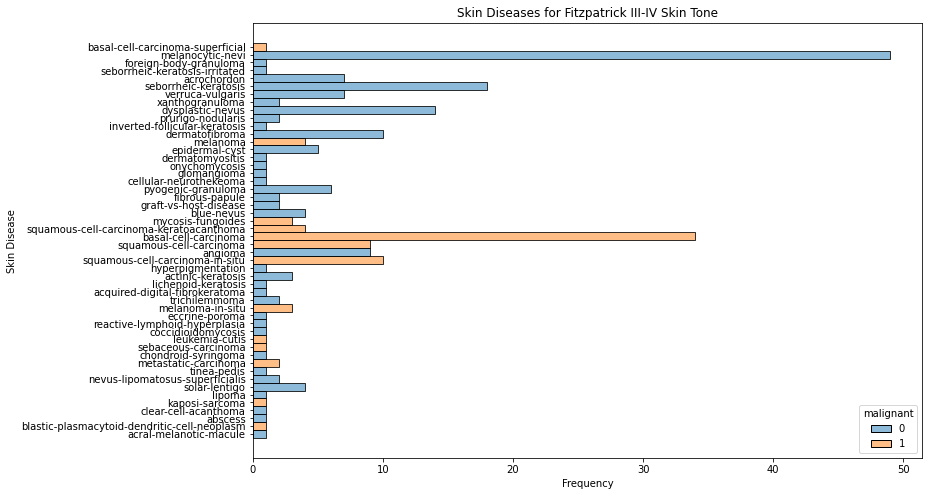

In [12]:
#histogram for top diseases of Fitzpatrick III-IV skin tone 
tone_34=csv.loc[csv['skin_tone']==34]

plt.figure(figsize=(12,8))
sns.histplot(data=tone_34, y='disease', hue='malignant')
plt.title('Skin Diseases for Fitzpatrick III-IV Skin Tone')
plt.ylabel('Skin Disease')
plt.xlabel('Frequency');

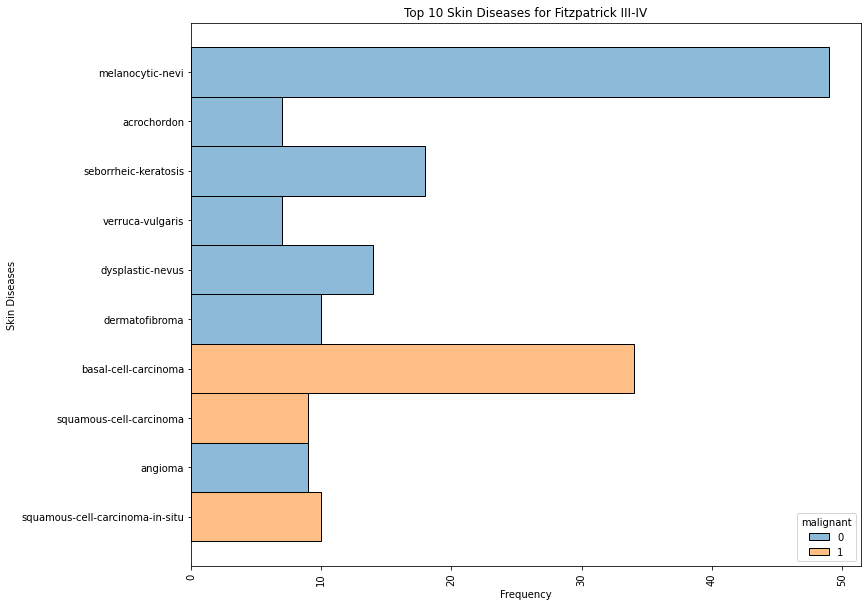

In [13]:
#finding top ten fitzpatrick III-IV skin diseases  
top_10_tone34=tone_34['disease'].value_counts().head(10).index.to_list()

loc_tone34=tone_34.loc[tone_34['disease'].isin(top_10_tone34)]

plt.figure(figsize=(12,10))
sns.histplot(data=loc_tone34, y='disease', hue='malignant')
plt.xticks(rotation=90)
plt.title('Top 10 Skin Diseases for Fitzpatrick III-IV')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

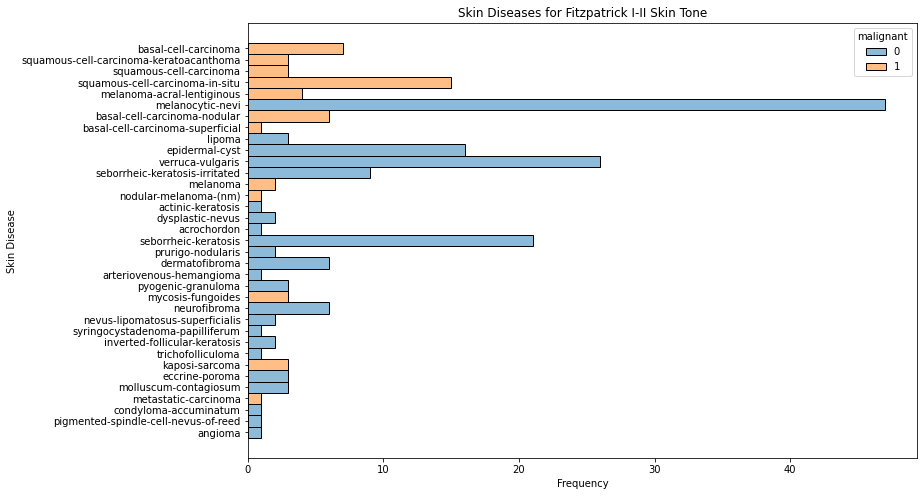

In [14]:
#histogram for top diseases of Fitzpatrick I-II skin tone 
tone_12=csv.loc[csv['skin_tone']==12]

plt.figure(figsize=(12,8))
sns.histplot(data=tone_12, y='disease', hue='malignant')
plt.title('Skin Diseases for Fitzpatrick I-II Skin Tone')
plt.ylabel('Skin Disease')
plt.xlabel('Frequency');

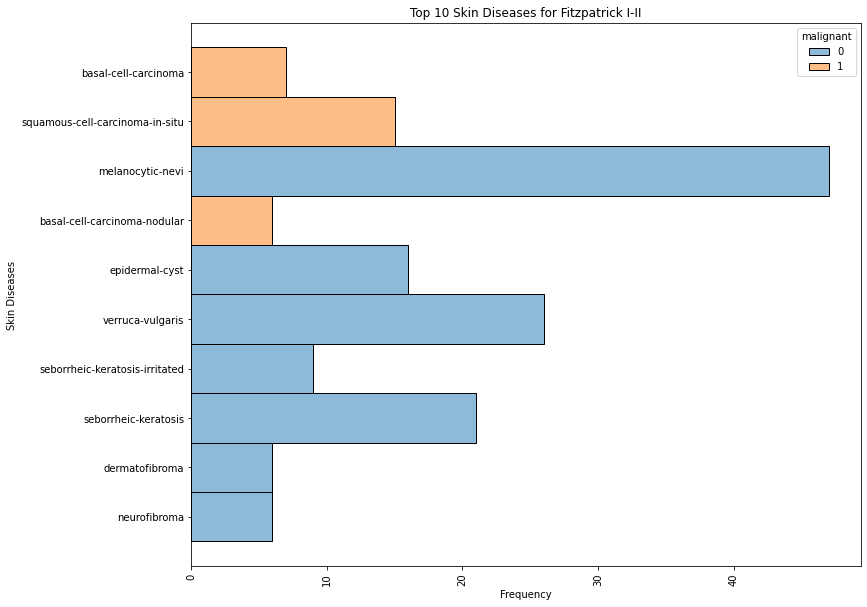

In [15]:
#finding top ten fitzpatrick I-II skin diseases  
top_10_tone12=tone_12['disease'].value_counts().head(10).index.to_list()

loc_tone12=tone_12.loc[tone_12['disease'].isin(top_10_tone12)]

plt.figure(figsize=(12,10))
sns.histplot(data=loc_tone12, y='disease', hue='malignant')
plt.xticks(rotation=90)
plt.title('Top 10 Skin Diseases for Fitzpatrick I-II')
plt.ylabel('Skin Diseases')
plt.xlabel('Frequency');

---

## Next Notebook: Pre-Processing/Modeling